# Calculating Eigenvalues  with Quantum Phase Estimation algorithm

In this demo we show how Quantum Phase Estimation algorithm can be used to calculate eigenvalues of a matrix.



## 1 Overview of Quantum Phase Estimation algorithm

Given a unitary operator $U$ with eigenvalues $e ^{2 \pi  i \phi}$ and eigenvectors $\left| u \right>$, QPE allows to find phase $\phi$. 

In order to do so, QPE requires 2 registers: 1 storing the input vector $\left| \psi \right>$, and 1 ancilla register that stores the $\phi$, as can be seen on the circuit schematic below.

The whole procedure is done in 3 steps:
1. The ancilla register is put in superposition by applying the H gates.
2. A series of U controlled rotations are applied on the $\left| \psi \right>$ register, which leave each kth ancilla qubit in state $\left| 0 \right> + e^{2 \pi i (2^{t-1})}\left| 1 \right> $
3. Inverse Fourier transform is applied on the ancilla register which leaves it in state $\left| \phi \right>$ that can be measured


<img src="Quantum_phase_estimation.png"  width="500 px" align="center">



## 2 Algorithm set up

This section explains step-by--step how the Quantum phase estimation algorithm is implemented in QISKit. 



### 2.1 Initiate
First we need to import the packages and initiate the program.

In [25]:
import sys
sys.path.append("..")

from qpe_hhl.qpe import QPE
from demo_functions import *
import numpy as np
from matrix_gen import gen_matrix
import matplotlib.pyplot as plt
qpe = QPE()

### 2.2 Define the matrix
Now, we are ready to define the matrix, for example:

In [26]:
matrix = gen_matrix(2, eigrange=[-4, 4], sparsity=0.6)  #random matrix
#or:
#matrix = np.matrix([[-1.5, -2], [-2,1.5]])                     #your own

n = len(matrix)                                         #n is the size of the system

[-2.74558349  2.71243377]
reduction factor: 0.75


### 2.3 Define the input state vector

In this next step we choose the input vector. If the input vector happens to be an eigenvector the system gets into eigenstate, and as a consequence the outcome of the QPE is only a single eigenvalue (that corresponds to this eigenvector). 

In case it is desired to find all the eigenvalues, the system needs to be in a superposition of all the eigenstates - therefore the input vector shall be a combination of all the eigenvectors.

In [27]:
invec = [1,1]

### 2.4 Define the algorithm parameters
Finally we choose the backend and the algorithm parameters:

In [28]:
backend = "local_qasm_simulator"

k = 3
nege = True

params = {
    'algorithm': {
            'name': 'QPE',
            'num_ancillae': k,                   #Increase #of ancilla qubits - increase precision of eigenvalues
            'num_time_slices': 3,               #Increase # of time slices - improves accuracy of Hamiltonian simulation
            'expansion_mode': 'suzuki',          #Approximation method for matrix exponentiation
            'expansion_order': 2,                #Number of terms in aforementioned approximation of matrix exponentiation 
            'hermitian_matrix': True,
            'negative_evals': nege,              #Flag: are negative eigenvalues allowed ?
            'backend' : backend,
            #'evo_time': 2*np.pi/4,
            #'use_basis_gates': False,
    },
    "iqft": {
        "name": "STANDARD"
    },
    "initial_state": {
        "name": "CUSTOM",
        "state_vector": invec
    }
}

## 3 Results

In the next step the algorithm is executed and the final results are retrieved. In this case the results are in form of a histogram.

The results obtained with the quantum computing aproach are compared with the classical.  

### 3.1 Executing on a Local Simulator

COMPLETED
{'backend': 'local_qasm_simulator_py', 'id': '793a51dd-22e8-4520-9bfd-534cd1c24953', 'job_id': '853295dc-5b67-4e96-88db-0e8c8bc616bc', 'result': [{'name': 'circuit16', 'seed': 483286512, 'shots': 1024, 'data': {'counts': {'011': 679, '010': 142, '100': 27, '110': 12, '111': 96, '101': 29, '000': 27, '001': 12}, 'snapshots': {}}, 'status': 'DONE', 'success': True, 'time_taken': 32.96644711494446}], 'status': 'COMPLETED', 'success': True, 'time_taken': 32.966487646102905}


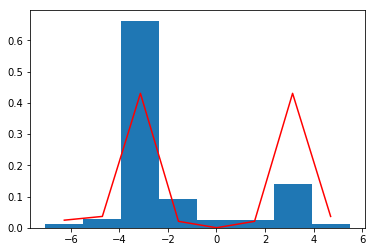

In [29]:
qpe.init_params(params, matrix)
qc = qpe._compute_eigenvalue()
res = qpe._ret

plot_res_and_theory(res, matrix, k, nege)

In [16]:
w, v = np.linalg.eig(matrix)
print('Actual eigenvalues:', w.real.round(2))

Actual eigenvalues: [0.83 0.62]


### 3.2 Executing on a Quantum Computer

Now lets solve the same problem on an actual Quantum computer, and see how the results compare.

In [30]:
import sys, time, getpass
try:
    sys.path.append("../../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
    print('Qconfig loaded from %s.' % Qconfig.__file__)
except:
    APItoken = getpass.getpass('Please input your token and hit enter: ')
    qx_config = {
        "APItoken": APItoken,
        "url":"https://quantumexperience.ng.bluemix.net/api"}
    print('Qconfig.py not found in qiskit-tutorial directory; Qconfig loaded using user input.')    

#from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QISKitError
from qiskit import available_backends, execute, register, get_backend, compile

register(qx_config['APItoken'], qx_config['url'])

available_backends(compact=False)

Qconfig loaded from ../../Qconfig.py.


QISKitError: 'The same provider has already been registered!'

In [31]:
params = {
    'algorithm': {
            'name': 'QPE',
            'num_ancillae': k,
            'num_time_slices': 3,
            'expansion_mode': 'suzuki',
            'expansion_order': 2,
            'hermitian_matrix': True,
            'negative_evals': nege,
            'backend' : 'ibmqx5',
            #'evo_time': 2*np.pi/4,
            #'use_basis_gates': False,
    },
    "iqft": {
        "name": "STANDARD"
    },
    "initial_state": {
        "name": "CUSTOM",
        "state_vector": invec#[1/2**0.5,1/2**0.5]
    }
}
# ibm_x5: max settings: for n = 2 k=3, suzuki, expansion order =2, -> max 3 time slices

COMPLETED
{'id': '5b855b7dafa155003dd8845b', 'status': 'COMPLETED', 'used_credits': 3, 'result': [{'data': {'time': 28.11955714225769, 'counts': {'000': 202, '001': 90, '100': 161, '101': 74, '010': 219, '011': 114, '110': 57, '111': 107}, 'date': '2018-08-28T14:28:14.194Z'}, 'name': 'circuit21', 'compiled_circuit_qasm': '\ninclude "qelib1.inc";\nqreg q[16];\ncreg c[3];\nu2(0,3.14159265358979) q[15];\nu3(1.57079632679490,0,0) q[2];\nu2(0,3.14159265358979) q[1];\nu1(6.28318530717959) q[0];\nbarrier q[2];\nu2(0.0611135740122069,3.14159265358979) q[2];\ncx q[1],q[2];\nu2(0,3.14159265358979) q[2];\nu2(0,3.14159265358979) q[1];\ncx q[1],q[2];\nu2(0,3.14159265358979) q[2];\nu2(0,3.14159265358979) q[1];\ncx q[1],q[2];\nu2(0,3.14159265358979) q[2];\nu2(0,3.14159265358979) q[1];\ncx q[1],q[0];\nu3(0.0611135740122069,1.57079632679490,4.71238898038469) q[1];\ncx q[1],q[0];\nu3(1.62382142802909,1.57079632679490,3.14159265358979) q[1];\ncx q[1],q[0];\nu3(-0.0530251012341972,1.57079632679490,4.71238

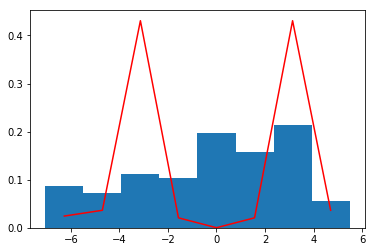

In [32]:
qpe = QPE()
qpe.init_params(params, matrix)
qc = qpe._compute_eigenvalue()
res_q = qpe._ret

plot_res_and_theory(res_q, matrix, k, nege)

## 3.3 Comparison of the results
You can see that the results from the actual Quantum computer are much more noisy - the peaks are not that sharp.

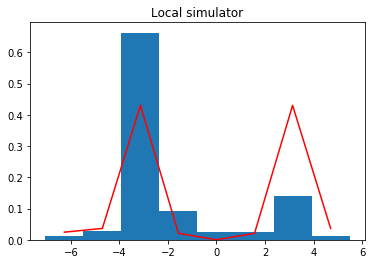

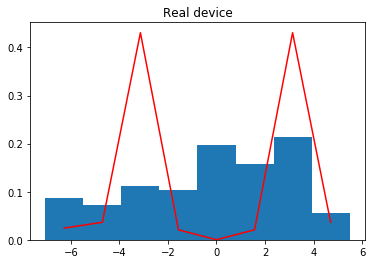

[[-1.40587167-5.55111512e-17j -1.76671283-1.53288575e+00j]
 [-1.76671283+1.53288575e+00j  1.40587167+5.55111512e-17j]]


In [34]:
plt.title('Local simulator')
plot_res_and_theory(res, matrix, k, nege)
plt.title('Real device')
plot_res_and_theory(res_q, matrix, k, nege)